In [1]:
# loading libraries

import  pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt
from datetime import datetime
from pytz import timezone
import pytz

In [2]:
# loading files as data frames

dataset_test = pd.read_csv('solar_test.csv')
dataset = pd.read_csv('solar_train.csv')

In [3]:
# exploring df colums

dataset.head()

UNIXTime                    Data      Time  Radiation  Temperature  \
0  1475175023   9/29/2016 12:00:00 AM  08:50:23     634.99           61   
1  1481799902  12/15/2016 12:00:00 AM  01:05:02       1.27           37   
2  1478339417   11/4/2016 12:00:00 AM  23:50:17       1.21           47   
3  1472887208    9/2/2016 12:00:00 AM  21:20:08       1.67           54   
4  1478724901   11/9/2016 12:00:00 AM  10:55:01     839.78           62   

   Pressure  Humidity  WindDirection(Degrees)  Speed TimeSunRise TimeSunSet  
0     30.46        41                   14.96   6.75    06:13:00   18:13:00  
1     30.26        70                  207.43   5.62    06:50:00   17:46:00  
2     30.49        33                  168.20   5.62    06:25:00   17:47:00  
3     30.46       101                  152.60   3.37    06:07:00   18:37:00  
4     30.47        36                  291.95   7.87    06:28:00   17:45:00

In [4]:
dataset_test.head()

id    UNIXTime                    Data      Time  Temperature  Pressure  \
0   0  1478720107   11/9/2016 12:00:00 AM  09:35:07           59     30.47   
1   1  1474063503   9/16/2016 12:00:00 AM  12:05:03           59     30.48   
2   2  1476109221  10/10/2016 12:00:00 AM  04:20:21           47     30.39   
3   3  1481475056  12/11/2016 12:00:00 AM  06:50:56           45     30.40   
4   4  1477493117  10/26/2016 12:00:00 AM  04:45:17           45     30.40   

   Humidity  WindDirection(Degrees)  Speed TimeSunRise TimeSunSet  
0        44                  312.67   3.37    06:28:00   17:45:00  
1        83                   38.01   6.75    06:10:00   18:25:00  
2        78                  213.62   5.62    06:16:00   18:03:00  
3        98                  176.63   4.50    06:47:00   17:44:00  
4        34                  175.89   6.75    06:21:00   17:52:00

In [5]:
# dercibing stats

dataset.describe()

UNIXTime     Radiation   Temperature      Pressure      Humidity  \
count  2.451400e+04  24514.000000  24514.000000  24514.000000  24514.000000   
mean   1.478049e+09    208.062687     51.105287     30.422713     75.002284   
std    3.006914e+06    316.133238      6.214280      0.054754     25.999994   
min    1.472724e+09      1.130000     34.000000     30.190000     11.000000   
25%    1.475532e+09      1.230000     46.000000     30.400000     55.000000   
50%    1.478047e+09      2.720000     50.000000     30.430000     85.000000   
75%    1.480482e+09    359.927500     55.000000     30.460000     97.000000   
max    1.483265e+09   1601.260000     71.000000     30.560000    103.000000   

       WindDirection(Degrees)         Speed  
count            24514.000000  24514.000000  
mean               143.129305      6.248435  
std                 82.939584      3.482597  
min                  0.090000      0.000000  
25%                 81.872500      3.370000  
50%                147.585000      5.620000  
75%                179.217500      7.870000  
max                359.950000     39.370000

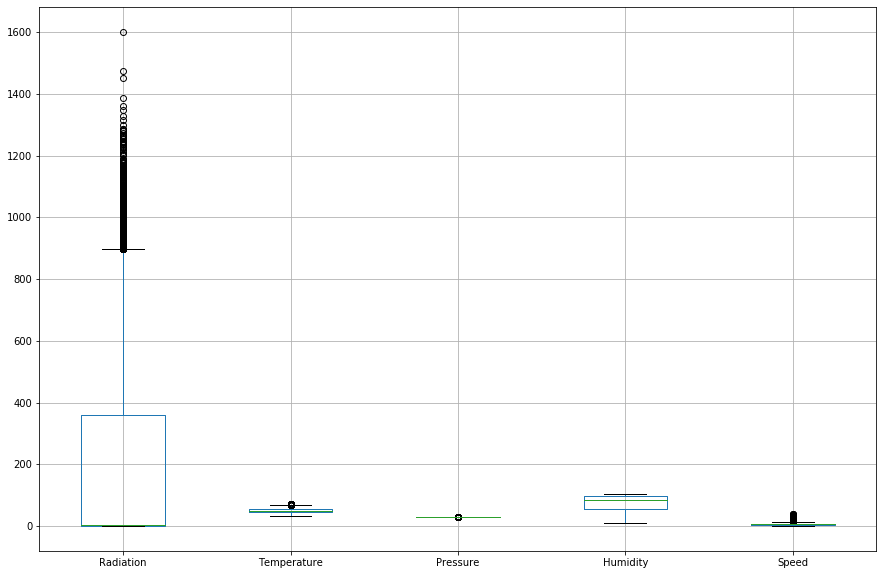

In [6]:
dataset.boxplot(column = ['Radiation','Temperature','Pressure','Humidity','Speed'],figsize = (15,10))

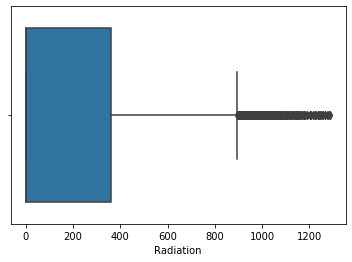

In [7]:
# getting rif of some outlier points in radiation

q1=np.percentile(dataset['Radiation'], 25)
q3=np.percentile(dataset['Radiation'], 73.5)

iqr=q3-q1

upper=q3+3*iqr
lower=q1-3*iqr
dataset = dataset[dataset['Radiation'] < upper]

sns.boxplot(x=dataset['Radiation'])

In [8]:
# lets work with time columns

def time_cols(dataset):
    hawaii= timezone('Pacific/Honolulu')
    dataset.index =  pd.to_datetime(dataset['UNIXTime'], unit='s')
    dataset.index = dataset.index.tz_localize(pytz.utc).tz_convert(hawaii)
    dataset['MonthOfYear'] = dataset.index.strftime('%m').astype(int)
    dataset['DayOfYear'] = dataset.index.strftime('%j').astype(int)
    dataset['WeekOfYear'] = dataset.index.strftime('%U').astype(int)
    dataset['TimeOfDay(h)'] = dataset.index.hour
    dataset['TimeOfDay(m)'] = dataset.index.hour*60 + dataset.index.minute
    dataset['TimeOfDay(s)'] = dataset.index.hour*60*60 + dataset.index.minute*60 + dataset.index.second
    dataset['TimeSunRise'] = pd.to_datetime(dataset['TimeSunRise'], format='%H:%M:%S')
    dataset['TimeSunSet'] = pd.to_datetime(dataset['TimeSunSet'], format='%H:%M:%S')
    dataset['DayLength(s)'] = dataset['TimeSunSet'].dt.hour*60*60 \
                               + dataset['TimeSunSet'].dt.minute*60 \
                               + dataset['TimeSunSet'].dt.second \
                               - dataset['TimeSunRise'].dt.hour*60*60 \
                               - dataset['TimeSunRise'].dt.minute*60 \
                               - dataset['TimeSunRise'].dt.second
    #dataset.drop(['Data','Time','TimeSunRise','TimeSunSet'], inplace=True, axis=1)
    dataset.drop(['Time','TimeSunRise','TimeSunSet'], inplace=True, axis=1)
    return dataset

In [9]:
# exploring new columns on dataset train

dataset_train = time_cols(dataset)
dataset_train.head()

UNIXTime                    Data  Radiation  \
UNIXTime                                                                   
2016-09-29 08:50:23-10:00  1475175023   9/29/2016 12:00:00 AM     634.99   
2016-12-15 01:05:02-10:00  1481799902  12/15/2016 12:00:00 AM       1.27   
2016-11-04 23:50:17-10:00  1478339417   11/4/2016 12:00:00 AM       1.21   
2016-09-02 21:20:08-10:00  1472887208    9/2/2016 12:00:00 AM       1.67   
2016-11-09 10:55:01-10:00  1478724901   11/9/2016 12:00:00 AM     839.78   

                           Temperature  Pressure  Humidity  \
UNIXTime                                                     
2016-09-29 08:50:23-10:00           61     30.46        41   
2016-12-15 01:05:02-10:00           37     30.26        70   
2016-11-04 23:50:17-10:00           47     30.49        33   
2016-09-02 21:20:08-10:00           54     30.46       101   
2016-11-09 10:55:01-10:00           62     30.47        36   

                           WindDirection(Degrees)  Speed  MonthOfYear  \
UNIXTime                                                                
2016-09-29 08:50:23-10:00                   14.96   6.75            9   
2016-12-15 01:05:02-10:00                  207.43   5.62           12   
2016-11-04 23:50:17-10:00                  168.20   5.62           11   
2016-09-02 21:20:08-10:00                  152.60   3.37            9   
2016-11-09 10:55:01-10:00                  291.95   7.87           11   

                           DayOfYear  WeekOfYear  TimeOfDay(h)  TimeOfDay(m)  \
UNIXTime                                                                       
2016-09-29 08:50:23-10:00        273          39             8           530   
2016-12-15 01:05:02-10:00        350          50             1            65   
2016-11-04 23:50:17-10:00        309          44            23          1430   
2016-09-02 21:20:08-10:00        246          35            21          1280   
2016-11-09 10:55:01-10:00        314          45            10           655   

                           TimeOfDay(s)  DayLength(s)  
UNIXTime                                               
2016-09-29 08:50:23-10:00         31823         43200  
2016-12-15 01:05:02-10:00          3902         39360  
2016-11-04 23:50:17-10:00         85817         40920  
2016-09-02 21:20:08-10:00         76808         45000  
2016-11-09 10:55:01-10:00         39301         40620

In [10]:
dataset_test = time_cols(dataset_test)
dataset_test.head()

id    UNIXTime                    Data  \
UNIXTime                                                            
2016-11-09 09:35:07-10:00   0  1478720107   11/9/2016 12:00:00 AM   
2016-09-16 12:05:03-10:00   1  1474063503   9/16/2016 12:00:00 AM   
2016-10-10 04:20:21-10:00   2  1476109221  10/10/2016 12:00:00 AM   
2016-12-11 06:50:56-10:00   3  1481475056  12/11/2016 12:00:00 AM   
2016-10-26 04:45:17-10:00   4  1477493117  10/26/2016 12:00:00 AM   

                           Temperature  Pressure  Humidity  \
UNIXTime                                                     
2016-11-09 09:35:07-10:00           59     30.47        44   
2016-09-16 12:05:03-10:00           59     30.48        83   
2016-10-10 04:20:21-10:00           47     30.39        78   
2016-12-11 06:50:56-10:00           45     30.40        98   
2016-10-26 04:45:17-10:00           45     30.40        34   

                           WindDirection(Degrees)  Speed  MonthOfYear  \
UNIXTime                                                                
2016-11-09 09:35:07-10:00                  312.67   3.37           11   
2016-09-16 12:05:03-10:00                   38.01   6.75            9   
2016-10-10 04:20:21-10:00                  213.62   5.62           10   
2016-12-11 06:50:56-10:00                  176.63   4.50           12   
2016-10-26 04:45:17-10:00                  175.89   6.75           10   

                           DayOfYear  WeekOfYear  TimeOfDay(h)  TimeOfDay(m)  \
UNIXTime                                                                       
2016-11-09 09:35:07-10:00        314          45             9           575   
2016-09-16 12:05:03-10:00        260          37            12           725   
2016-10-10 04:20:21-10:00        284          41             4           260   
2016-12-11 06:50:56-10:00        346          50             6           410   
2016-10-26 04:45:17-10:00        300          43             4           285   

                           TimeOfDay(s)  DayLength(s)  
UNIXTime                                               
2016-11-09 09:35:07-10:00         34507         40620  
2016-09-16 12:05:03-10:00         43503         44100  
2016-10-10 04:20:21-10:00         15621         42420  
2016-12-11 06:50:56-10:00         24656         39420  
2016-10-26 04:45:17-10:00         17117         41460

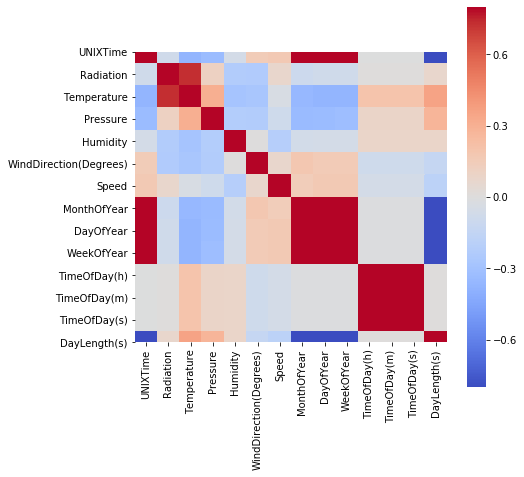

In [11]:
# Watching correlations
corrmat = dataset_train.corr()
f, ax = plt.subplots(figsize=(7,7))
sns.heatmap(corrmat, vmin=-.8, vmax=.8, square=True, cmap = 'coolwarm')
plt.show()


In [12]:
# we will drop some columns with high correlation

#data_train = dataset_train.drop(['TimeOfDay(h)', 'TimeOfDay(m)', 'TimeOfDay(s)', 'DayOfYear','MonthOfYear', 'WeekOfYear'], inplace=False, axis=1)
data_train = dataset_train.drop(['UNIXTime', 'Data'], inplace=False, axis=1)
data_train.head()

Radiation  Temperature  Pressure  Humidity  \
UNIXTime                                                                
2016-09-29 08:50:23-10:00     634.99           61     30.46        41   
2016-12-15 01:05:02-10:00       1.27           37     30.26        70   
2016-11-04 23:50:17-10:00       1.21           47     30.49        33   
2016-09-02 21:20:08-10:00       1.67           54     30.46       101   
2016-11-09 10:55:01-10:00     839.78           62     30.47        36   

                           WindDirection(Degrees)  Speed  MonthOfYear  \
UNIXTime                                                                
2016-09-29 08:50:23-10:00                   14.96   6.75            9   
2016-12-15 01:05:02-10:00                  207.43   5.62           12   
2016-11-04 23:50:17-10:00                  168.20   5.62           11   
2016-09-02 21:20:08-10:00                  152.60   3.37            9   
2016-11-09 10:55:01-10:00                  291.95   7.87           11   

                           DayOfYear  WeekOfYear  TimeOfDay(h)  TimeOfDay(m)  \
UNIXTime                                                                       
2016-09-29 08:50:23-10:00        273          39             8           530   
2016-12-15 01:05:02-10:00        350          50             1            65   
2016-11-04 23:50:17-10:00        309          44            23          1430   
2016-09-02 21:20:08-10:00        246          35            21          1280   
2016-11-09 10:55:01-10:00        314          45            10           655   

                           TimeOfDay(s)  DayLength(s)  
UNIXTime                                               
2016-09-29 08:50:23-10:00         31823         43200  
2016-12-15 01:05:02-10:00          3902         39360  
2016-11-04 23:50:17-10:00         85817         40920  
2016-09-02 21:20:08-10:00         76808         45000  
2016-11-09 10:55:01-10:00         39301         40620

In [13]:
#data_test = dataset_test.drop(['id','TimeOfDay(h)', 'TimeOfDay(m)', 'TimeOfDay(s)', 'DayOfYear','MonthOfYear', 'WeekOfYear'], inplace=False, axis=1)
data_test = dataset_test.drop(['UNIXTime', 'Data'], inplace=False, axis=1)
data_test.head()

id  Temperature  Pressure  Humidity  \
UNIXTime                                                         
2016-11-09 09:35:07-10:00   0           59     30.47        44   
2016-09-16 12:05:03-10:00   1           59     30.48        83   
2016-10-10 04:20:21-10:00   2           47     30.39        78   
2016-12-11 06:50:56-10:00   3           45     30.40        98   
2016-10-26 04:45:17-10:00   4           45     30.40        34   

                           WindDirection(Degrees)  Speed  MonthOfYear  \
UNIXTime                                                                
2016-11-09 09:35:07-10:00                  312.67   3.37           11   
2016-09-16 12:05:03-10:00                   38.01   6.75            9   
2016-10-10 04:20:21-10:00                  213.62   5.62           10   
2016-12-11 06:50:56-10:00                  176.63   4.50           12   
2016-10-26 04:45:17-10:00                  175.89   6.75           10   

                           DayOfYear  WeekOfYear  TimeOfDay(h)  TimeOfDay(m)  \
UNIXTime                                                                       
2016-11-09 09:35:07-10:00        314          45             9           575   
2016-09-16 12:05:03-10:00        260          37            12           725   
2016-10-10 04:20:21-10:00        284          41             4           260   
2016-12-11 06:50:56-10:00        346          50             6           410   
2016-10-26 04:45:17-10:00        300          43             4           285   

                           TimeOfDay(s)  DayLength(s)  
UNIXTime                                               
2016-11-09 09:35:07-10:00         34507         40620  
2016-09-16 12:05:03-10:00         43503         44100  
2016-10-10 04:20:21-10:00         15621         42420  
2016-12-11 06:50:56-10:00         24656         39420  
2016-10-26 04:45:17-10:00         17117         41460

## Some regression models

In [14]:
X = data_train.drop(columns = ['Radiation'],axis=1)
y = data_train['Radiation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.13, random_state=42)
X.head()

Temperature  Pressure  Humidity  \
UNIXTime                                                     
2016-09-29 08:50:23-10:00           61     30.46        41   
2016-12-15 01:05:02-10:00           37     30.26        70   
2016-11-04 23:50:17-10:00           47     30.49        33   
2016-09-02 21:20:08-10:00           54     30.46       101   
2016-11-09 10:55:01-10:00           62     30.47        36   

                           WindDirection(Degrees)  Speed  MonthOfYear  \
UNIXTime                                                                
2016-09-29 08:50:23-10:00                   14.96   6.75            9   
2016-12-15 01:05:02-10:00                  207.43   5.62           12   
2016-11-04 23:50:17-10:00                  168.20   5.62           11   
2016-09-02 21:20:08-10:00                  152.60   3.37            9   
2016-11-09 10:55:01-10:00                  291.95   7.87           11   

                           DayOfYear  WeekOfYear  TimeOfDay(h)  TimeOfDay(m)  \
UNIXTime                                                                       
2016-09-29 08:50:23-10:00        273          39             8           530   
2016-12-15 01:05:02-10:00        350          50             1            65   
2016-11-04 23:50:17-10:00        309          44            23          1430   
2016-09-02 21:20:08-10:00        246          35            21          1280   
2016-11-09 10:55:01-10:00        314          45            10           655   

                           TimeOfDay(s)  DayLength(s)  
UNIXTime                                               
2016-09-29 08:50:23-10:00         31823         43200  
2016-12-15 01:05:02-10:00          3902         39360  
2016-11-04 23:50:17-10:00         85817         40920  
2016-09-02 21:20:08-10:00         76808         45000  
2016-11-09 10:55:01-10:00         39301         40620

In [17]:
# XGBR regressor
import xgboost as xgb
from xgboost import DMatrix as XGBM

xgbm = xgb.DMatrix(X_train,y_train)
param={'n_trees': 50, 
    'eta': 0.04,
    'max_depth': 5,
    'subsample': 0.6,
    'objective': 'reg:linear',
    'max_leaves': 32,  
    'eval_metric': 'rmse',
    'silent': 1}
model_1 = xgb.train(param,xgbm)

testings = xgb.DMatrix(X_test)
y_pred = model_1.predict(testings)

predictions_1 = pd.DataFrame(y_pred,columns=['Radiation']) 

MSE = mean_squared_error(y_test.values, y_pred[:3187])

print(MSE)

68636.83024586977


In [19]:
# Bayessian grid searching
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
# Standard params
space={
    'n_estimators':hp.quniform('n_estimators', 10, 1000, 25),
    
    'learning_rate':hp.uniform('learning_rate', 0.0001, 1.0),
    
    'max_depth':hp.quniform('x_max_depth', 4, 16, 1),
    
    'min_child_weight':hp.quniform('x_min_child', 1, 10, 1),
    
    'subsample':hp.uniform('x_subsample', 0.7, 1),
    
    'gamma':hp.uniform('x_gamma', 0.1, 0.5),
    
    'reg_lambda':hp.uniform('x_reg_lambda', 0, 1)
}

# Function to get best params with the model XGBR

def objetivo(space):
    
    modelo=xgb.XGBRegressor(
        n_estimators=int(space['n_estimators']),
        learning_rate=space['learning_rate'],
        max_depth=int(space['max_depth']),
        min_child_weight=space['min_child_weight'],
        subsample=space['subsample'],
        gamma=space['gamma'],
        reg_lambda=space['reg_lambda'],
        objective='reg:squarederror'
    )
    
    eval_set=[(X_train, y_train), (X_test, y_test)]
    
    modelo.fit(X_train, y_train, eval_set=eval_set, eval_metric='rmse', verbose=False)
    
    y_pred=modelo.predict(X_test)
    
    rmse=mean_squared_error(y_test, y_pred)**0.5
    
    return {'loss':rmse, 'status':STATUS_OK}

trials_reg=Trials()

best=fmin(fn=objetivo, space=space, algo=tpe.suggest, max_evals=10, trials=Trials())

best

100%|██████████| 10/10 [01:49<00:00, 10.99s/trial, best loss: 78.07834367236025]


{'learning_rate': 0.03955186852665695,
 'n_estimators': 625.0,
 'x_gamma': 0.27168855283020943,
 'x_max_depth': 12.0,
 'x_min_child': 5.0,
 'x_reg_lambda': 0.9972170616580629,
 'x_subsample': 0.9118593436599851}

In [20]:
modelo=xgb.XGBRegressor(
    n_estimators=int(best['n_estimators']),
    learning_rate=best['learning_rate'],
    x_max_depth=int(best['x_max_depth']),
    x_min_child=best['x_min_child'],
    x_subsample=best['x_subsample'],
    x_gamma=best['x_gamma'],
    x_reg_lambda=best['x_reg_lambda'],
    objective='reg:squarederror'
    )

In [22]:
modelo.fit(X_train, y_train)
y_pred=modelo.predict(X_test)
mean_squared_error(y_test.values, y_pred[:3187])

6232.549858550419

In [34]:
from lightgbm import LGBMRegressor as LGBMR      # LGBMRegressor
from catboost import CatBoostRegressor as CTR     # CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor as GBR  # GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor as KNNR    # KNeighborsRegressor
from sklearn.linear_model import SGDRegressor as SGDR    # SGDRegressor
from sklearn.tree import ExtraTreeRegressor as ETR    # ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor as RFR   # RandomForestRegressor
from sklearn.svm import SVR    # SVR
from sklearn.linear_model import LinearRegression as LinReg    # Common linreg

def best_mse(data_train):
    
    X = data_train.drop(columns = ['Radiation'],axis=1)
    y = data_train['Radiation']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.13, random_state=42)
    
    
    lgbmr = LGBMR()
    lgbmr.fit(X_train, y_train)
    y_pred = lgbmr.predict(X_test)
    lgbmr_result = mean_squared_error(y_test.values, y_pred[:3187])
    
    ctr=CTR(verbose=0)
    ctr.fit(X_train, y_train)
    y_pred = ctr.predict(X_test)
    ctr_result = mean_squared_error(y_test.values, y_pred[:3187])
    
    gbr = GBR()
    gbr.fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    gbr_result = mean_squared_error(y_test.values, y_pred[:3187])

    knnr = KNNR(n_neighbors=7)
    knnr.fit(X_train, y_train)
    y_pred = knnr.predict(X_test)
    knnr_result = mean_squared_error(y_test.values, y_pred[:3187])
    
    sgdr = SGDR(max_iter=800)
    sgdr.fit(X_train, y_train)
    y_pred = sgdr.predict(X_test)
    sgdr_result = mean_squared_error(y_test.values, y_pred[:3187])
    
    etr = ETR()
    etr.fit(X_train, y_train)
    y_pred = etr.predict(X_test)
    etr_result = mean_squared_error(y_test.values, y_pred[:3187])

    rfr = RFR()
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    rfr_result = mean_squared_error(y_test.values, y_pred[:3187])
    
    svr = SVR()
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    svr_result = mean_squared_error(y_test.values, y_pred[:3187])

    linreg=LinReg()
    linreg.fit(X_train, y_train)
    y_pred=linreg.predict(X_test)
    linreg_result = mean_squared_error(y_test.values, y_pred[:3187])

    return('''LGBMRegressor: {} \n
              CatBoostRegressor: {} \n 
              GradientBoostingRegressor: {} \n
              KNeighborsRegressor: {} \n
              SGDRegressor: {} \n
              ExtraTreeRegressor: {} \n
              RandomForestRegressor: {} \n
              SVR: {} \n
              Common linreg : {} \n'''.format(lgbmr_result,ctr_result,gbr_result,knnr_result,sgdr_result,etr_result,rfr_result,svr_result,linreg_result))

In [35]:
print(best_mse(data_train))

LGBMRegressor: 6386.678201105044 

              CatBoostRegressor: 5996.870630549922 
 
              GradientBoostingRegressor: 11100.529317111897 

              KNeighborsRegressor: 17371.727068692107 

              SGDRegressor: 3.1860158931948927e+34 

              ExtraTreeRegressor: 13349.47960634024 

              RandomForestRegressor: 6331.94586857789 

              SVR: 73412.49512257804 

              Common linreg : 37237.86529047366 



We can see that the best MSE is obtained with regression models like CatBoostRegressor and RandomForestRegressor, also we could apply grid searching to improve parameters but we will try to get the best MSE with other ways like H2O.ai Acuarium dashboard or PYCARET.


## Next step H2O.ai Acuarium and PYCARET

We should save both frameworks, train and test to ".csv" files, and then export the files to the H2O.ai Acuarium dashboard.
Remembering that we have transformed and deleted Data column.

In [15]:
#data_train.to_csv(r'train4.csv',index=False)
#data_test.to_csv(r'test4.csv',index=False)

![title](Datasets/exp9.png)

Making some tests moving ACCURACY, TIME AND INTERPRETABILITY. We´v got a final MSE = 5981.17 in kaggle score.